<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/NMDAExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
Detailed=True # Change for whether or not you want to use the detailed or reduced order model

In [2]:
github=False # Change between 0 and 1 for whether or not you want to get the model from github or google drive
#Github isn't working right now because you need the data on Github, but the data is too large to upload.

import shutil
if github==True: # If you do not already have the model, comment the above and uncomment below
  # shutil.rmtree('Stylized-ReducedOrder-L5-Model/') #removes folder if already cloned
  !git clone https://github.com/davidfague/Stylized-ReducedOrder-L5-Model.git
  %cd Stylized-ReducedOrder-L5-Model/
else: #If you have the folder in your google drive (easier to update geom_parameters)
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Stylized-ReducedOrder-L5-Model/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Stylized-ReducedOrder-L5-Model


In [3]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
# import ZipFile

In [4]:
if Detailed == True:
  output_folder = 'Detailedoutput_control'
  segs = pd.read_csv('DetailedSegments.csv')
  degrees_f='L5DetailedSectionDegrees.csv'
  # ZipFile.extractall(path='Detailedoutput_control', members=None, pwd=None) #possible implementation for unzipping data from github
else:
  output_folder = 'output_control'
  segs = pd.read_csv('L5Segments.csv')
  degrees_f='SegmentsDegrees.csv'

conns = pd.read_csv('./{}/Connections.csv'.format(output_folder))

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/Stylized-Cell-model/

In [6]:

# for p in segs[(segs.Type=='dend')].index:
#   threshold_crossings = np.diff(v['report']['biophysical']['data'][:,15] > -40, prepend=False)
#   upward_crossings = np.argwhere(threshold_crossings)[::2,0]
#   print(p)
#   if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
#     legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>260]
#     print('if')
#   else:
#     legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>260]
#     print('else')



# print(legit_up_crossings)

In [7]:
def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    #print('volt')
    #print(threshold_crossings)
    #print(upward_crossings)
    #print(downward_crossings)
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        #print('if')
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        #print('else')
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current



In [8]:
conns.head()

,Node ID,Distance,Conductance,Type,Name,Source Population,Release Probability
0,0,61.505696,0.500607,dend,L5PCtemplate[0].dend[60](0.264706),exc_stim,0.6
1,0,112.522057,0.325079,dend,L5PCtemplate[0].dend[28](0.128571),exc_stim,0.6
2,0,73.494480,0.554728,dend,L5PCtemplate[0].dend[29](0.7),exc_stim,0.6
3,0,101.530468,1.005930,dend,L5PCtemplate[0].dend[33](0.264706),exc_stim,0.6
4,0,65.675576,0.304560,dend,L5PCtemplate[0].dend[48](0.409091),exc_stim,0.6


In [9]:
#print(conns)

In [10]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))

In [11]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))

conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

In [12]:
conns.head()

,Node ID,conns_Distance,Conductance,Type,Name,Source Population,Release Probability,Sec ID,X
0,0,61.505696,0.500607,dend,L5PCtemplate[0].dend[60](0.264706),exc_stim,0.6,60,0.264706
1,0,112.522057,0.325079,dend,L5PCtemplate[0].dend[28](0.128571),exc_stim,0.6,28,0.128571
2,0,73.494480,0.554728,dend,L5PCtemplate[0].dend[29](0.7),exc_stim,0.6,29,0.700000
3,0,101.530468,1.005930,dend,L5PCtemplate[0].dend[33](0.264706),exc_stim,0.6,33,0.264706
4,0,65.675576,0.304560,dend,L5PCtemplate[0].dend[48](0.409091),exc_stim,0.6,48,0.409091


In [13]:
# segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Sec ID','Type'])['Degrees'].max().reset_index()
print(segs)
# print(segs_degrees)
segs.head()
segs['segmentID'] = segs.index
# print(segs['segmentID'])
# segIDs=segs['segmentID']
# print(segIDs)
# segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()
segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'
# segIDs=segs['segmentID']
try:
  segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False, duplicates = 'drop')
  segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False, duplicates = 'drop')
except:
  print('Elec_distance missing')

      segmentID  BMTK ID     Seg_L   Seg_diam         X  Type  Sec ID  \
0             0        0  4.633872   9.290377  0.100000  soma       0   
1             1        0  4.633872  15.657015  0.300000  soma       0   
2             2        0  4.633872  17.526643  0.500000  soma       0   
3             3        0  4.633872  15.446328  0.700000  soma       0   
4             4        0  4.633872   9.437299  0.900000  soma       0   
...         ...      ...       ...        ...       ...   ...     ...   
2521       2521      195  4.285714   1.000000  0.357143  axon       1   
2522       2522      195  4.285714   1.000000  0.500000  axon       1   
2523       2523      195  4.285714   1.000000  0.642857  axon       1   
2524       2524      195  4.285714   1.000000  0.785714  axon       1   
2525       2525      195  4.285714   1.000000  0.928571  axon       1   

       Distance  Section_L  Section_diam  Section_nseg  Section_Ra    Coord X  \
0      2.316936  23.169362     17.526643  

In [14]:
exc_syns_per_seg = conns[conns['Source Population']=='exc_stim'].groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})




In [15]:
exc_syns_per_seg.head()

,Type,Sec ID,X,num_syns
0,apic,0,0.055556,10
1,apic,0,0.166667,5
2,apic,0,0.277778,17
3,apic,0,0.388889,4
4,apic,0,0.500000,3


In [16]:
segs['segmentID'] = segs.groupby(['Type','Sec ID']).cumcount()+1

In [17]:
exc_syns_per_seg['segmentID'] = exc_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1

In [18]:
exc_syns = segs.set_index(['Type','Sec ID','segmentID']).join(exc_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()


In [19]:
v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')


#v['report']['biophysical']['data'][:]

In [20]:
v['report']['biophysical']['data'][:-100,1]

array([-80.00650007, -80.01106238, -79.8164152 , ..., -66.66345765,
       -66.77398003, -66.82112798])

In [21]:
v_thresh = -40
np.diff(v['report']['biophysical']['data'][:-10000,1]> v_thresh, prepend=False)

array([], dtype=bool)

In [22]:
spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [23]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    #print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > (0.003/1000), prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        na_df = na_df.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
                                               'na_lower_bound':na_spks}))
    else:
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':np.array([np.nan])}))

In [24]:
na_df.to_csv('na_df.csv')
na_df = pd.read_csv('na_df.csv')


na_df.index

RangeIndex(start=0, stop=90618, step=1)

In [25]:

#display(na_df.to_string())

In [26]:

for i in np.random.choice(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)].index,1000):
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        # import pdb; pdb.set_trace()
        # duration = np.arange(0,20)[trace>half_peak] + spkt - 10 #gave occasional error
        duration = np.arange(0,len(trace))[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [27]:
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [28]:
segs_na_df = segs.join(na_df.set_index('segmentID')).reset_index()
# display(segs_na_df.Type.to_string())
# display(segs_na_df.Elec_distance.to_string())


na_df.head



#segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&(segs_na_df.Type=='apic')]

<bound method NDFrame.head of        Unnamed: 0  segmentID  na_lower_bound  duration_low  duration_high  \
0               0          5              66           NaN            NaN   
1               1          5             654           NaN            NaN   
2               2          5            4532           NaN            NaN   
3               3          5            5852           NaN            NaN   
4               4          5            6111           NaN            NaN   
...           ...        ...             ...           ...            ...   
90613          33       2511            8688           NaN            NaN   
90614          34       2511            8715           NaN            NaN   
90615          35       2511            9495           NaN            NaN   
90616          36       2511            9916           NaN            NaN   
90617          37       2511            9964           NaN            NaN   

       peak_value  duration  
0             N

In [29]:
segs_na_df[~pd.isnull(segs_na_df.duration_high)]

,index,segmentID,BMTK ID,Seg_L,Seg_diam,X,Type,Sec ID,Distance,Section_L,...,Coord Z,ParentSegID,Elec_distance,Elec_distanceQ,Unnamed: 0,na_lower_bound,duration_low,duration_high,peak_value,duration
35,8,4,1,4.840176,1.17,0.700000,dend,0,28.525296,24.200878,...,2.003011,7.0,0.598685,9,7.0,6100.0,6102.0,6109.0,0.000007,0.8
220,14,2,3,4.891969,0.58,0.048387,dend,2,58.305710,151.651052,...,7.367501,13.0,0.214118,8,6.0,2028.0,2036.0,2037.0,0.000084,0.2
440,19,7,3,4.891969,0.58,0.209677,dend,2,82.765557,151.651052,...,11.018781,18.0,0.103129,6,31.0,8158.0,8165.0,8167.0,0.000016,0.3
463,20,8,3,4.891969,0.58,0.241935,dend,2,87.657526,151.651052,...,13.717749,19.0,0.093350,6,12.0,3339.0,3329.0,3348.0,0.000005,2.0
607,23,11,3,4.891969,0.58,0.338710,dend,2,102.333434,151.651052,...,21.228432,22.0,0.072608,5,27.0,7866.0,7858.0,7875.0,0.000003,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90050,2487,14,190,4.930463,0.58,0.710526,apic,105,147.625808,93.678791,...,-36.624526,2486.0,0.065452,6,11.0,4625.0,4630.0,4634.0,0.000127,0.5
90063,2488,15,190,4.930463,0.58,0.763158,apic,105,152.556271,93.678791,...,-39.869379,2487.0,0.061131,6,4.0,1039.0,1038.0,1048.0,0.000004,1.1
90499,2508,4,193,4.296385,0.58,0.500000,apic,108,118.187074,30.074693,...,-39.022675,2507.0,0.100352,7,19.0,4519.0,4517.0,4528.0,0.000005,1.2
90524,2509,5,193,4.296385,0.58,0.642857,apic,108,122.483459,30.074693,...,-41.897120,2508.0,0.091714,7,11.0,2975.0,2977.0,2984.0,0.000009,0.8


In [30]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#print(na_df)

In [31]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
   # print(edges_dend)
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
   # print('please')
    actual_spktimes = []
    c = 0

   # print(spktimes)


    for i in np.sort(spktimes):
        # excludes bursts
        #print(i)
        if i-c > 10:
            for e in np.arange(0,10):
                #print(e)
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
                #print(na_inds)
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    

    
    
    return na_dend, na_apic

In [32]:
na_dend, na_apic = get_sta(segs_na_df, spktimes)

In [33]:
#print(na_apic)

In [34]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [35]:
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

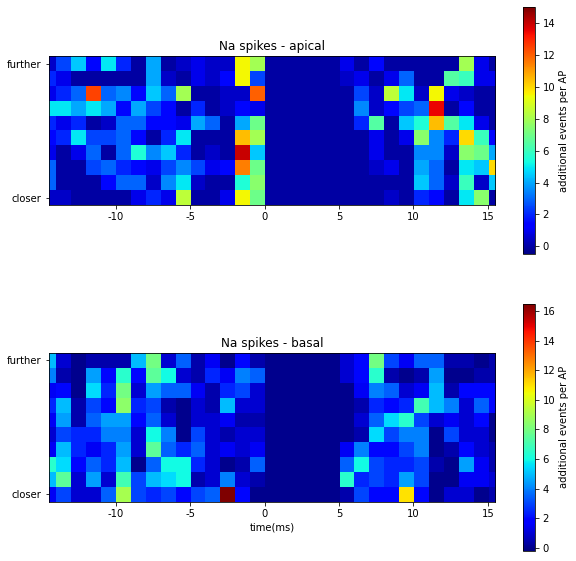

In [36]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow((na_apic-na_apic_rand)/len(spktimes),cmap='jet',vmin=-0.5)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
# plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2, vmax=0.2)
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

----------

In [37]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])

segs['segmentID'] = segs.index
# segIDs = segs[(segs.Type=='apic')]['segmentID'] #original
segIDs = segs['segmentID']
for p in segIDs:
    # import pdb; pdb.set_trace()
    #print(p)
    trace = hva['report']['biophysical']['data'][:,p]+\
                lva['report']['biophysical']['data'][:,p]+\
                ih['report']['biophysical']['data'][:,p]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=200)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc

    # print(legit_dc_iso)
    
    
    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=hva['report']['biophysical']['data'])
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan}))

In [38]:
#print(ca_df)

In [39]:
ca_df.to_csv('ca_df.csv')
ca_df = pd.read_csv('ca_df.csv')

# durations

In [40]:
segs[(segs['Coord Y']>600)&(segs['Coord Y']<800)]

,segmentID,BMTK ID,Seg_L,Seg_diam,X,Type,Sec ID,Distance,Section_L,Section_diam,Section_nseg,Section_Ra,Coord X,Coord Y,Coord Z,ParentSegID,Elec_distance,Elec_distanceQ
1486,1486,122,5.024998,1.80,0.118182,apic,37,671.034720,276.374877,1.29,55,100.0,-34.973857,603.914939,1.574586,1485.0,0.118966,7
1487,1487,122,5.024998,1.80,0.136364,apic,37,676.059718,276.374877,1.29,55,100.0,-35.172710,608.816781,2.648283,1486.0,0.115345,7
1488,1488,122,5.024998,1.80,0.154545,apic,37,681.084716,276.374877,1.29,55,100.0,-35.172710,613.744600,3.629033,1487.0,0.111910,7
1489,1489,122,5.024998,1.80,0.172727,apic,37,686.109714,276.374877,1.29,55,100.0,-34.968832,618.393979,5.477332,1488.0,0.108648,7
1490,1490,122,5.024998,1.80,0.190909,apic,37,691.134711,276.374877,1.29,55,100.0,-35.410425,623.307217,5.993446,1489.0,0.105547,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1842,1842,145,4.960289,1.03,0.627660,apic,60,846.627753,233.133572,1.03,47,100.0,-47.270383,778.441926,-7.096120,1841.0,0.024395,4
1843,1843,145,4.960289,1.03,0.648936,apic,60,851.588041,233.133572,1.03,47,100.0,-48.492018,783.156060,-7.837240,1842.0,0.023730,4
1844,1844,145,4.960289,1.03,0.670213,apic,60,856.548330,233.133572,1.03,47,100.0,-49.419451,787.982406,-8.215281,1843.0,0.023097,4
1845,1845,145,4.960289,1.03,0.691489,apic,60,861.508619,233.133572,1.03,47,100.0,-49.467465,792.908083,-8.094590,1844.0,0.022493,4


In [41]:
np.random.choice(segs[(segs['Coord Y']<-50)&
     (segs['Coord Y']>-100)&
     (segs['Coord X']>-50)&
     (segs['Coord X']<50)&
     (segs['Type']=='dend')]['segmentID'])

809

## Plotting morphology as heat maps

In [42]:
exc_syns.shape

(2526, 19)

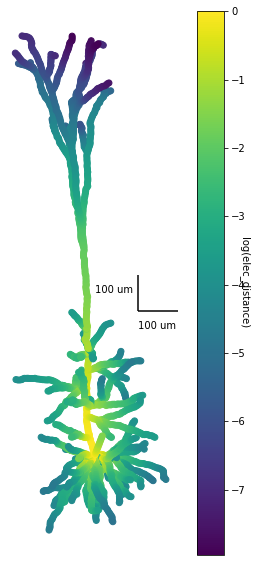

In [43]:
plt.figure(figsize=(4,10))
ax = plt.scatter(exc_syns['Coord X'], exc_syns['Coord Y'],c=np.log(exc_syns['Elec_distance']))
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

In [44]:
exc_syns.loc[pd.isnull(exc_syns.num_syns),'num_syns'] = 0

In [45]:
exc_syns[exc_syns.num_syns==0].shape, exc_syns[exc_syns.num_syns!=0].shape

((537, 19), (1989, 19))

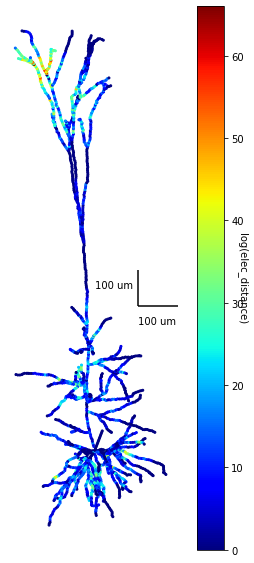

In [46]:
plt.figure(figsize=(4,10))
ax = plt.scatter(exc_syns['Coord X'], exc_syns['Coord Y'],c=exc_syns['num_syns'],s=4,cmap='jet')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

## Plotting morphology and voltage traces

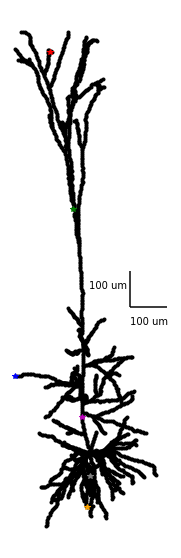

In [47]:
plt.figure(figsize=(3,10))
ax = plt.plot(segs['Coord X'], segs['Coord Y'],'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(segs.loc[segs.segmentID==1959,'Coord X'], 
         segs.loc[segs.segmentID==1959,'Coord Y'],
         'r*')
plt.plot(segs.loc[segs.segmentID==1112,'Coord X'], 
         segs.loc[segs.segmentID==1112,'Coord Y'],
         'b*')
plt.plot(segs.loc[segs.segmentID==1046,'Coord X'], 
         segs.loc[segs.segmentID==1046,'Coord Y'],
         'm*')
plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
         segs.loc[segs.segmentID==1500,'Coord Y'],
         'g*')
plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
         segs.loc[segs.segmentID==680,'Coord Y'],
         '*',color='orange')
plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
         segs.loc[segs.segmentID==482,'Coord Y'],
         '*',color='grey')
plt.savefig('fig1A.svg')

In [48]:
#v = h5py.File('../../../L5NeuronSimulation_expts/L5_control/L5_control_exc_med/L5NeuronSimulation/FullSimulation/output/v_report.h5','r')


In [49]:
#t

641


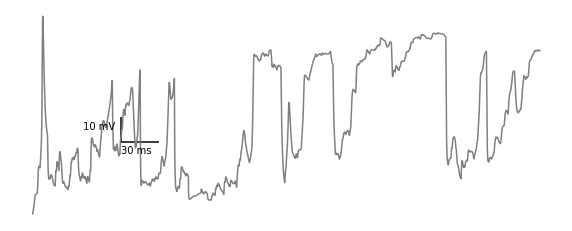

In [50]:
t = np.random.choice(segs[(segs['Coord Y']<-50)&
     (segs['Coord Y']>-100)&
     (segs['Coord X']>-50)&
     (segs['Coord X']<50)&
     (segs['Type']=='dend')]['segmentID'])

print(t)

plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='grey')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2G.svg')

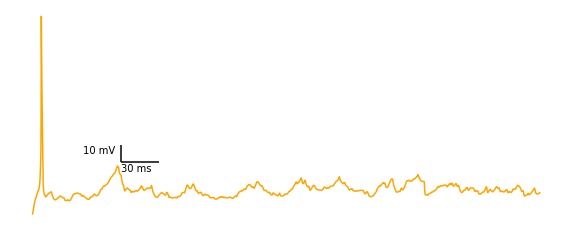

In [51]:
plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,130],color='orange')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2F.svg')

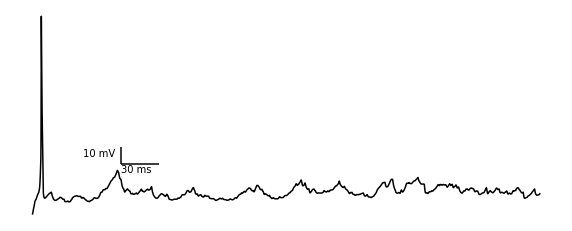

In [52]:
plt.figure(figsize=(10,4))
s1 = 3 #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2E.svg')

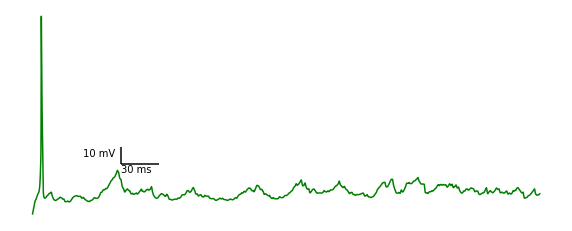

In [53]:
plt.figure(figsize=(10,4))
s1 =  3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000, 4],color='g')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2C.svg')

In [54]:
# plt.figure(figsize=(10,4))
# #s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
# plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,3],color='m')
# #1433413, 1161455
# plt.hlines(-50,70,100)
# plt.text(70,-55,'30 ms')
# plt.vlines(70,-50,-40)
# plt.text(40,-45,'10 mV')
# plt.box(False)
# plt.xticks([])
# plt.yticks([])
# plt.savefig('fig2D.svg')

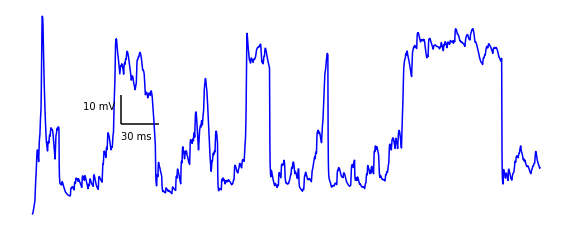

In [55]:
plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,70],color='b')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2B.svg')

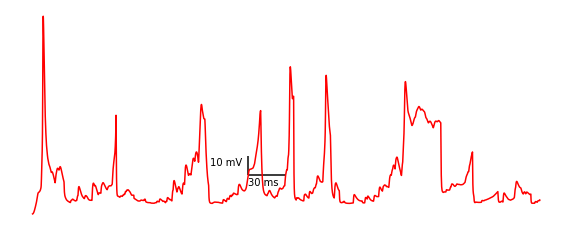

In [56]:
plt.figure(figsize=(10,4))
s1 = 3 #323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000, 30],color='r')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'30 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2A.svg')

In [57]:
s1

3

([], <a list of 0 Text major ticklabel objects>)

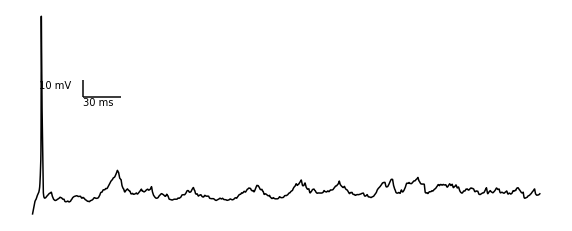

In [58]:
plt.figure(figsize=(10,4))
#s1 = 559133+1000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-10,40,70)
plt.text(40,-15,'30 ms')
plt.vlines(40,-10,0)
plt.text(5,-5,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [59]:
# x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
# i = np.random.choice(x.index)

(0.0, 200.0)

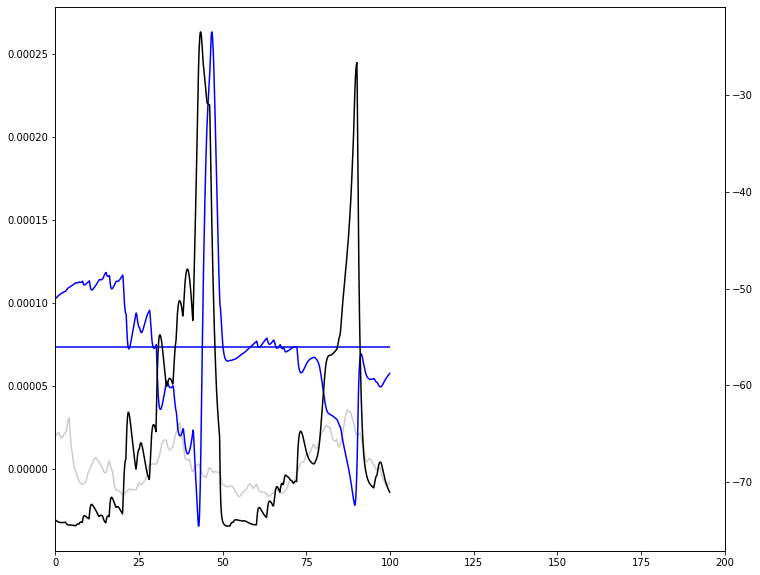

In [60]:
seg = 30
lower_bound = 1000
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,100,.1),-(hva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         lva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         ih['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]),color='b')
plt.hlines(np.mean(-(hva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         lva['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg]+\
         ih['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg])),0,100,color='b')
plt.xlim(0,200)

plt.twinx()
plt.plot(np.arange(0,100,.1),v['report']['biophysical']['data'][lower_bound-100:lower_bound+900,seg],color='k')
plt.plot(np.arange(0,100,.1),v['report']['biophysical']['data'][lower_bound-100:lower_bound+900,0],color='k',alpha=0.2)
plt.xlim(0,200)


In [61]:
ca_df.reset_index(inplace=True)


In [62]:
ca_df

,index,Unnamed: 0,segmentID,ca_lower_bound,ca_upper_bound,mag
0,0,0,0,NaN,NaN,NaN
1,1,0,1,NaN,NaN,NaN
2,2,0,2,NaN,NaN,NaN
3,3,0,3,NaN,NaN,NaN
4,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...
11054,11054,0,2521,NaN,NaN,NaN
11055,11055,0,2522,NaN,NaN,NaN
11056,11056,0,2523,NaN,NaN,NaN
11057,11057,0,2524,NaN,NaN,NaN


In [63]:
ca_df[(ca_df.ca_lower_bound>20) & (ca_df.ca_lower_bound<1400000)]

,index,Unnamed: 0,segmentID,ca_lower_bound,ca_upper_bound,mag
17,17,0,17,6120.0,6376.0,-0.002686
18,18,0,18,6120.0,6380.0,-0.004001
19,19,0,19,6120.0,6383.0,-0.005349
20,20,0,20,6120.0,6386.0,-0.006799
21,21,0,21,4619.0,4863.0,-0.004068
...,...,...,...,...,...,...
10906,10906,1,2376,2929.0,3227.0,-0.092138
10907,10907,2,2376,8536.0,8774.0,-0.079931
10908,10908,0,2377,1643.0,1858.0,-0.074300
10909,10909,1,2377,2929.0,3227.0,-0.095291


In [64]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>20) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        
        trace = -(hva['report']['biophysical']['data'][spkt-100:spkt+200,seg] + \
                lva['report']['biophysical']['data'][spkt-100:spkt+200,seg] + \
                ih['report']['biophysical']['data'][spkt-100:spkt+200,seg])
        peak_value = np.max(trace) # may recieve error here if trace is empty. in that case, check segmentID and seg
        half_peak = peak_value/2
        duration = np.arange(0,300)[trace>half_peak] + spkt - 10
        ca_df.loc[i,'duration_low'] = duration[0]
        ca_df.loc[i,'duration_high'] = duration[-1]
        ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

ValueError: ignored

In [ ]:
ca_df[~pd.isnull(ca_df.duration_high)]

In [ ]:
seg = 90
lower_bound = 150
#upper_bound = 
plt.plot(-(hva['report']['biophysical']['data'][lower_bound-100:lower_bound+600,seg]+\
         lva['report']['biophysical']['data'][lower_bound-100:lower_bound+600,seg]+\
         ih['report']['biophysical']['data'][lower_bound-100:lower_bound+600,seg]))
plt.plot(1000,-(hva['report']['biophysical']['data'][lower_bound,seg]+\
         lva['report']['biophysical']['data'][lower_bound,seg]+\
         ih['report']['biophysical']['data'][lower_bound,seg]),'*')

plt.plot(1000-lower_bound,-(hva['report']['biophysical']['data'][150,seg]+\
         lva['report']['biophysical']['data'][150,seg]+\
         ih['report']['biophysical']['data'][150,seg]),'*')

plt.twinx()
plt.plot(v['report']['biophysical']['data'][lower_bound-100:lower_bound+1000,seg],color='k')

----------

In [ ]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index() 

In [ ]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,39,))
    
    edges_apic=np.quantile(segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                       (segs_ca_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='apic')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                ca_apic[e] += x2
                
                
            
            actual_spktimes.append(i)
        c = i
    return ca_apic

In [ ]:
ca_apic = get_ca_sta(segs_ca_df, spktimes)

In [ ]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca spikes - apical')
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.colorbar(label='events per AP')
plt.yticks(ticks=[0,9],labels=['further','closer'])

plt.show()

----------------------

In [ ]:
#apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

#basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


In [ ]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index: #(segs.Type=='dend')|(segs.Type=='apic')
    #print(p)
    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc

    #print(legit_uc)
    #print(legit_dc)
    
    if (len(legit_uc_iso)!=0) & (np.min(nmda['report']['biophysical']['data'][:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['report']['biophysical']['data'])


        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
        #print(nmda_df.mag)
    
    else:
        #print('else')
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))


#display(nmda_df.mag.to_string())


#min(nmda_df.mag)

In [ ]:
#nmda_df.to_csv('nmda_df.csv')
#nmda_df = pd.read_csv('nmda_df.csv')


In [ ]:
#mda_df.mag <= -0.000000001

In [ ]:
#segs_nmda_df[:]

In [ ]:
#nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [ ]:
segs_nmda_df = segs.join(nmda_df.set_index('segmentID')).reset_index()

In [ ]:
segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]

In [ ]:
#min(segs_nmda_df.mag)

In [ ]:
#segs_nmda_df[(segs_nmda_df.mag<-0.0001)]

In [ ]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.00001)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [ ]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spktimes)

In [ ]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [ ]:
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.2)
# plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.2,vmax=0.2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.2)
# plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.2, vmax=0.2)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

In [ ]:
sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='dend'])

In [ ]:
total_basal_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='dend'][~pd.isnull(segs_nmda_df.mag)])
num_basal_seg = len(segs[segs.Type=='dend'])

total_apic_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='apic'][~pd.isnull(segs_nmda_df.mag)])
num_apic_seg = len(segs[segs.Type=='apic'])

apic_nmda_perSeg_perSec = total_apic_nmda / num_apic_seg
basal_ndma_perSeg_perSec = total_basal_nmda / num_basal_seg

data = {'basal':basal_ndma_perSeg_perSec, 'apic':apic_nmda_perSeg_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))
plt.title('NMDA spikes per segment per second')


# creating the bar plot
plt.barh(group, value, color ='lightseagreen')

In [ ]:
total_basal_na = sum(segs_na_df['segmentID'][segs_na_df.Type=='dend'][~pd.isnull(segs_na_df.duration_high)])
num_basal_seg = len(segs[segs.Type=='dend'])

total_apic_na = sum(segs_na_df['segmentID'][segs_na_df.Type=='apic'][~pd.isnull(segs_na_df.duration_high)])
num_apic_seg = len(segs[segs.Type=='apic'])

apic_na_perSeg_perSec = total_apic_na / num_apic_seg
basal_na_perSeg_perSec = total_basal_na / num_basal_seg

data = {'basal':basal_na_perSeg_perSec, 'apic':apic_na_perSeg_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))
plt.title('Na spikes per segment per second')


# creating the bar plot
plt.barh(group, value, color ='powderblue')

In [ ]:
total_basal_ca = sum(segs_ca_df['index'][segs_ca_df.Type=='dend'][~pd.isnull(segs_ca_df.duration_high)])
num_basal_seg = len(segs[segs.Type=='dend'])

print(total_basal_ca)

total_apic_ca = sum(segs_ca_df['index'][segs_ca_df.Type=='apic'][~pd.isnull(segs_ca_df.duration_high)])
num_apic_seg = len(segs[segs.Type=='apic'])

apic_ca_perSeg_perSec = total_apic_ca / num_apic_seg
basal_ca_perSeg_perSec = total_basal_ca / num_basal_seg


data = {'basal':basal_ca_perSeg_perSec, 'apic':apic_ca_perSeg_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.title('Calcium spikes per segment per second')

 
# creating the bar plot
plt.barh(group, value, color ='tomato')

In [ ]:
for i in np.arange(0,10):
    plt.plot(np.arange(-40,95,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [ ]:
# segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

In [ ]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['Coord X'], segs['Coord Y'], 'b.')
plt.plot(segs.loc[0,'Coord X'], segs.loc[0,'Coord Y'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'Coord X'], segs.loc[ind,'Coord Y'], 'r*',markersize=20)

# for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==2)]['Sec ID'].unique():
#     plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#              segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='r')
    
#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')
    
#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
plt.ylim(-25,50)
plt.xlim(-150,150)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.plot(f['report']['biophysical']['data'][:,119],color='b')
# plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
# plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

# plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
# plt.plot(f['report']['biophysical']['data'][:,0],'k')
# plt.twinx()
# plt.plot(h['report']['biophysical']['data'][:,119],color='r')
# plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
# plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

# plt.xlim(526519-100,526519+1000)

In [ ]:
nmda2 = np.zeros((79,))

for i in spktimes:
    nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
             (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
             (segs_nmda_df.mag<-0.1)&
                (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

    x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
    nmda2 += x2
    
    #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
    #na3 += x3
    
    #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
    #na4 += x4
    
    #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
    #na5 += x5
    

In [ ]:
plt.plot(nmda2)

In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# ind = 1139
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
# plt.ylim(-0.009,0.001)
# plt.xlim(37000,39000)
# plt.ylabel('current (nA)')


In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
# plt.xlim(32000,32400)
# plt.ylim(-0.009,0.001)
# plt.ylabel('current (nA)')


In [ ]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [ ]:
np.arange(-30,31,5).shape

In [ ]:
plt.plot(np.arange(-30,30,5),n)

In [ ]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

In [ ]:
# plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
#          na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

In [ ]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [ ]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
# plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
# plt.xlim(6000,7000)

In [ ]:
# # ind1 = 3 sent to Drew
# ind1 = 2
# e1 = control_inmda[legit_uc_iso[ind1], p]
# e2 = control_inmda[legit_dc_iso[ind1], p]
# x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
# x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
# plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.ylabel('current (nA)')
# plt.ylim(-0.010,0)
# plt.legend(loc='upper center')
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


# for i in np.arange(0,len(bounds)):
#     plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#     plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

In [ ]:
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
# plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

# uc = voltage_criterion(control_v[:,p],-40)[0]


# plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


# center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

# plt.plot([center,center+26],[-80,-80],color='k')
# plt.legend(loc='lower left')

# plt.twinx()
# plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
# #plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
# plt.xlim(center-100,center+100)

# plt.legend(loc='lower right')
# plt.title('{}'.format(legit_uc))

In [ ]:
# p = np.random.choice(segs[segs.Type=='apic'].index)
# for i in spktimes:
#     plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
# plt.vlines(10,-65,0,color='k')
# plt.ylim(-65,0)

In [ ]:
# p = 829#np.random.choice(segs[segs.Type=='dend'].index)
# plt.title('dend {}'.format(p))
# plt.plot(control_v[7200:7700,p],label='dend')
# plt.plot(control_v[7200:7700,0],label='soma')
# plt.hlines(-40,0,500)
# plt.twinx()
# plt.plot(control_inmda[7200:7700,p],color='r')
# plt.legend()

In [ ]:
# control_v[10000,0]

In [ ]:
# plt.hist(control_v[10000,:])

In [ ]:
# plt.plot(control_v[:,1200])
# plt.plot(NMDAblock_v[:,1200])

In [ ]:
# df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [ ]:
# df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

In [ ]:
# df[(df.Distance>900) & (df.Distance<1000)]

In [ ]:
# plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
# plt.xlim(1740,1760)

In [ ]:
# plt.figure(figsize=(10,6))
# plt.scatter(df['Distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
# plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
# plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
# plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
# plt.xlabel('distance from soma')
# plt.ylabel('mean potential of segment (mV)')

In [ ]:
# #plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

# plt.figure(figsize=(10,6))

# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
# plt.xlim(1.75,2)
# plt.xlabel('time (s)')
# plt.ylabel('membrane potential (mV)')